In [16]:
import geopandas as gpd
cells = gpd.read_file("../.data/segments_voronoi.geojson")
cells.head()

,geometry
0,"POLYGON ((-122.676219812442 45.52808846480664,..."
1,POLYGON ((-122.5255831150746 45.46325002917997...
2,POLYGON ((-122.7450110508624 45.46647382691764...
3,"POLYGON ((-122.7962442790204 45.582584694634, ..."
4,POLYGON ((-122.7909081432284 45.58210025261987...


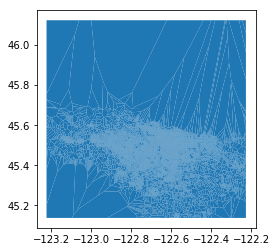

In [86]:
cells.plot()

In [18]:
streets = gpd.read_file('../.data/combined_filtered_segment_midpoints.geojson')
streets.head()

,name,geometry
0,NW BROADWAY,POINT (-122.6776160529759 45.52768417667291)
1,SE CLATSOP ST,POINT (-122.5245687848956 45.46127391776403)
2,SW GARDEN HOME RD,POINT (-122.7446068876164 45.4656802013666)
3,NW SKYLINE BLVD,POINT (-122.7981387983939 45.58058331478398)
4,NW SKYLINE BLVD,POINT (-122.7952966986207 45.57815267653617)


In [19]:
streets_as_cell = gpd.sjoin(cells, streets, how="inner", op='intersects')
streets_as_cell.head()

,geometry,index_right,name
0,"POLYGON ((-122.676219812442 45.52808846480664,...",0,NW BROADWAY
1,POLYGON ((-122.5255831150746 45.46325002917997...,1,SE CLATSOP ST
2,POLYGON ((-122.7450110508624 45.46647382691764...,2,SW GARDEN HOME RD
3,"POLYGON ((-122.7962442790204 45.582584694634, ...",3,NW SKYLINE BLVD
4,POLYGON ((-122.7909081432284 45.58210025261987...,4,NW SKYLINE BLVD


In [20]:
len(streets_as_cell)

22610

In [21]:
len(streets)

23042

In [22]:
len(cells)

22664

In [43]:
streets_as_cell = streets_as_cell[['name', 'geometry']]
streets_as_cell.to_file(filename='../.data/segments_voronoi.geojson', driver='GeoJSON')

In [24]:
import pandas as pd
from sqlalchemy import create_engine

In [25]:
import json

with open('../.config/connection_strings.json') as json_file:  
    data = json.load(json_file)
    
if data is not None:
    connection_string = data['scooter_pilot_1']
    
engine = create_engine(connection_string)

In [94]:
sql = """
select t.key as tripkey
,cs.date as startdate
,t.starttime
,ce.date as enddate
,t.endtime
,t.startx
,t.starty
,t.endx
,t.endy
from fact.trip as t
inner join dim.calendar as cs on cs.key = t.startdatekey
inner join dim.calendar as ce on ce.key = t.enddatekey
"""

trips = pd.read_sql(sql, engine)

In [95]:
from shapely.geometry import Point
trips['origin'] = list(zip(trips.startx, trips.starty))
trips['origin'] = trips['origin'].apply(Point)

In [96]:
trips['destination'] = list(zip(trips.endx, trips.endy))
trips['destination'] = trips['destination'].apply(Point)

In [97]:
trips_with_cell = gpd.sjoin(trips.set_geometry('origin'), streets_as_cell, how="inner", op='intersects')

/opt/conda/lib/python3.7/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [98]:
cell_counts = trips_with_cell[['tripkey', 'index_right']].groupby(['index_right'])

In [99]:
streets_as_cell['index'] = streets_as_cell.index

In [105]:
merged = pd.merge(streets_as_cell, cell_counts.count(), left_on='index', right_on='index_right')

(-122.7, -122.65, 45.5, 45.55)

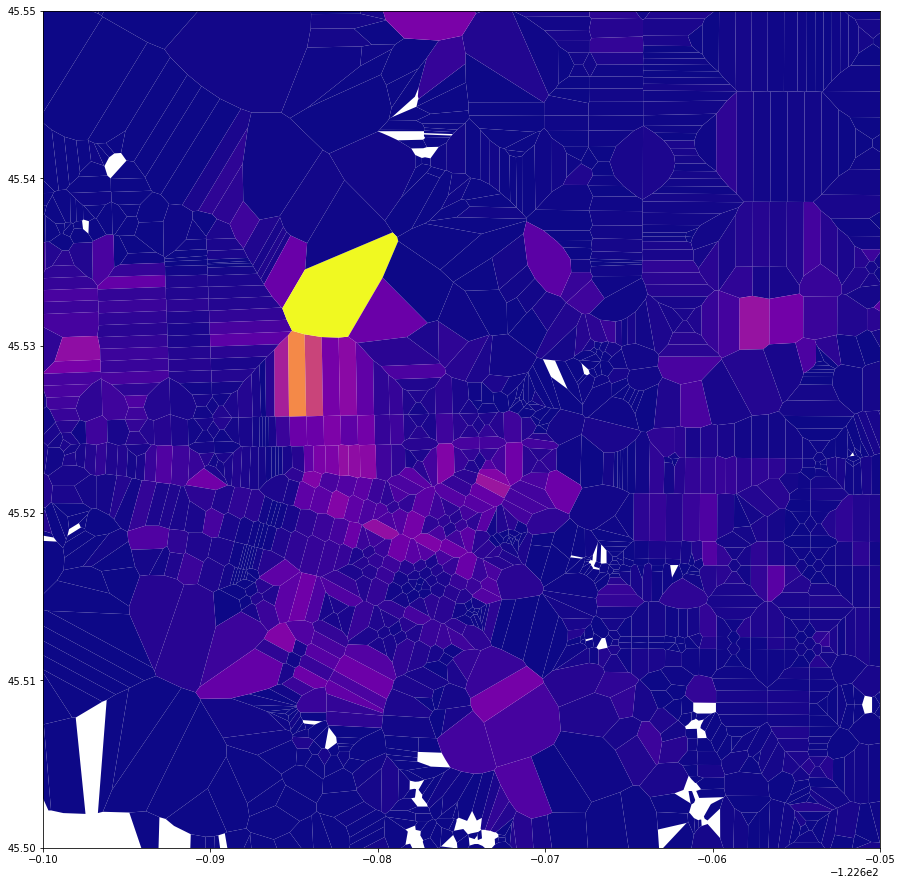

In [134]:
import matplotlib.pyplot as plt

merged.plot(figsize=(15,20), column='trips', cmap='plasma')
plt.axis((-122.7,-122.65, 45.5, 45.55))

In [106]:
merged = merged.rename(index=str, columns={'tripkey': 'trips'})

In [107]:
merged.to_file('../.data/segments_voronoi_counts.geojson', driver='GeoJSON')

In [115]:
cities = gpd.read_file('../.data/cities.geojson')
cities.columns.to_list()

['OBJECTID', 'CITYNAME', 'Shape_Length', 'Shape_Area', 'AREA', 'geometry']

In [116]:
cities = cities[cities['CITYNAME'] == 'Portland']
len(cities)

1

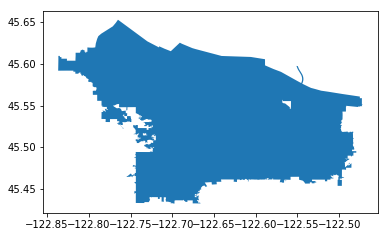

In [122]:
ax = cities.plot()

In [123]:
merged.plot(ax=ax, figsize=(20,15), column='trips', cmap='PuOr')

<Figure size 432x288 with 0 Axes>